# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import norm
from scipy.stats import ttest_ind
from numpy.random import seed
medical = pd.read_csv('insurance2.csv')

In [2]:
medical.shape

(1338, 8)

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__

In [4]:
print(f'Mean of Charges is {round(np.mean(medical.charges), 2)} and Std of Charges is {round(np.std(medical.charges), 2)}')

Mean of Charges is 13270.42 and Std of Charges is 12105.48


In [5]:
medical.loc[medical.insuranceclaim == 0, 'charges'].mean()

8821.421892306294

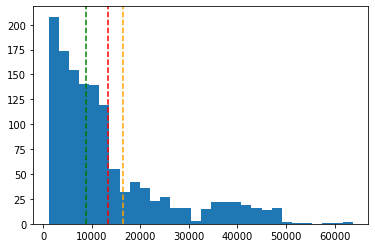

In [6]:
_ = plt.hist(medical.charges, bins = 30)
plt.axvline(13270, color = 'red', linestyle = '--')
plt.axvline(medical.loc[medical.insuranceclaim == 0, 'charges'].mean(), color = 'green', linestyle = '--')
plt.axvline(medical.loc[medical.insuranceclaim == 1, 'charges'].mean(), color = 'orange', linestyle = '--')
plt.show()

As you can see from the above plot, the distribution is long tailed, and the standard deviation is very large because of outliers in the data. Some patients would have more complicated surgeries which would incur higher medical costs than the average medical costs.

__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:Given that the distribution is not normally distributed from the sample, it would be advisable to get bootstrap estimates of the mean and sample with replacement. With an increase in n, the population charges would approach a normal distribution.__

In [7]:
def sample(data, n = 1338):
    return np.random.choice(data, n, replace = True)

In [8]:
sample(medical.charges)

array([ 7954.517  ,  4454.40265,  2497.0383 , ..., 11763.0009 ,
        6079.6715 ,  2639.0429 ])

In [9]:
def samplingdist(data, n = 10000):
    return pd.DataFrame({'mean_charges':[sample(medical.charges).mean() for i in range (n)]})

In [10]:
bootstrap = samplingdist(medical.charges)

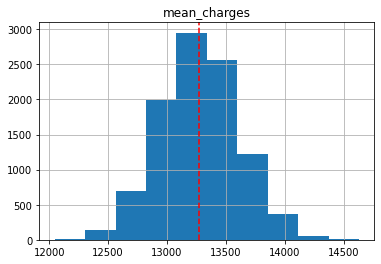

In [11]:
bootstrap.hist()
plt.axvline(13270, color = 'red', linestyle = '--')

In [12]:
norm.ppf(0.05)

-1.6448536269514729

In [13]:
mean = np.mean(bootstrap.mean_charges)
sigma = np.std(bootstrap.mean_charges)
two_sided_interval = sigma * norm.ppf(0.975)

print(f'Standard deviation of bootstrap samples {np.std(bootstrap.mean_charges)}')
print(f'Z Value of bootstrap samples {round(norm.ppf(0.975), 2)}')
print(f'Margin of Error = Z-value * Sigma --> {sigma * round(norm.ppf(0.975), 2)}')
print(f'Two sided 95 % Confidence Interval is: [{round(mean - two_sided_interval, 2)}, {round(mean + two_sided_interval, 2)}]')


Standard deviation of bootstrap samples 331.48433230257353
Z Value of bootstrap samples 1.96
Margin of Error = Z-value * Sigma --> 649.7092913130441
Two sided 95 % Confidence Interval is: [12624.39, 13923.78]


__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

__A:The administrator should be concerned because the lowest most mean charges at 95% confidence Interval is 12729 however the operating costs are at 12000 which are below this limit__

In [14]:
mean = np.mean(bootstrap.mean_charges)
sigma = np.std(bootstrap.mean_charges)
one_sided_interval = sigma * norm.ppf(0.05)
print(f'One sided 95 % Confidence Interval is: [{round(mean + one_sided_interval, 2)}]')

One sided 95 % Confidence Interval is: [12728.84]


The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

**What assumption about the variances of the two groups are we making here?**

__A__:
Null Hypothesis -- n0 -- People with insurance are **NOT** charged a different amount to those without. mu1 = mu2

Alternate Hypothesis -- n1 -- People with insurance are charged a different amount to those without. mu1 is not = mu2

__What assumption about the variances of the two groups are we making here?__
We are assuming the variance of the two groups is independent of each other. **NOT SURE ABOUT THIS**

__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

In [15]:
mu1 = medical.loc[medical.insuranceclaim == 1, 'charges'].mean()
sigma1 = medical.loc[medical.insuranceclaim == 1, 'charges'].std()
n1 = len(medical.loc[medical.insuranceclaim == 1, 'charges'])
mu0 = medical.loc[medical.insuranceclaim == 0, 'charges'].mean()
sigma0 = medical.loc[medical.insuranceclaim == 0, 'charges'].std()
n0 = len(medical.loc[medical.insuranceclaim == 0, 'charges'])
print(f'mu1: {mu1}, sigma1: {sigma1}, n1:{n1}')
print(f'mu0: {mu0}, sigma0: {sigma0}, n0:{n0}')

mu1: 16423.928276537663, sigma1: 14045.928418802127, n1:783
mu0: 8821.421892306294, sigma0: 6446.510126811736, n0:555


In [16]:
sp = np.sqrt((((n0 - 1)* sigma0**2) + ((n1 - 1)* sigma1**2)) / (n0 + n1 - 2))
print(sp)

11520.034268775256


In [17]:
t_statistic = (mu0 - mu1) / (sp * np.sqrt(1/n0 + 1/n1))
print(t_statistic)

-11.89329903087671


In [18]:
pval = t.sf(np.abs(t_statistic), len(medical.charges)-1)*2  # two-sided pvalue = Prob(abs(t)>tt)
print(pval)

4.45016623302336e-31


In [19]:
ttest_ind(medical.loc[medical.insuranceclaim == 0, 'charges'], medical.loc[medical.insuranceclaim == 1, 'charges'])

Ttest_indResult(statistic=-11.893299030876712, pvalue=4.461230231620717e-31)

As you can see, the manual calculations equal the ttest_ind

__A:Indeed the two means of insurance claims are different and we can reject the null hypothesis and conclude that the mean charges of insurance claims are different than those people without insurance claims__ 

Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:The Z-test is used when the population standard deviation is known. However, if the population standard deviation is not known, then we use a T-Test by using the standard deviation of the sample divided by the square root of the sample size__

__The T-Distribution is similar to the standard normal distribution but it has thicker tails for N close to 30.__ 

__In the T-Distribution, we are estimating the true population standard deviation. However, for really large samples, the T-Distribution would approach the Standard normal distribution__

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test